In [1]:
import os
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
import tensorflow as tf
import tensorflow.keras as keras
import subprocess
from PIL import Image
import matplotlib.pyplot as plt
import imgaug as ia
import numpy as np
from imgaug import augmenters as iaa

DATASET_PATH = '../classification_data'

2022-11-17 12:30:38.624352: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 12:30:38.789461: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-17 12:30:39.356791: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/lib64:
2022-11-17 12:30:39.356859: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

In [2]:
dataset_files = os.listdir(DATASET_PATH)

dataset_files = list(filter(lambda x: x.endswith('.png'), dataset_files))
np.random.shuffle(dataset_files)

val_ratio = 0.3

In [3]:
val_files = dataset_files[:int(len(dataset_files)*val_ratio)]
train_files = dataset_files[int(len(dataset_files)*val_ratio):]

In [4]:
len(val_files), len(train_files)

(1804, 4212)

In [5]:
aug_pipeline = iaa.Sequential([
        iaa.Resize({"height": 64, "width": 64}),
        iaa.Sometimes(0.5, iaa.GaussianBlur((0, 1.0))),
        iaa.Sometimes(0.8, iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-45, 45),
            shear=(-12, 12),
            order=[0, 1],
            cval=(0, 255),
            mode=ia.ALL
        )),
        iaa.SomeOf(
            (2, 5),
            [
                iaa.Fliplr(1.0),
                iaa.Flipud(1.0),
                iaa.Sometimes(0.5, iaa.CropAndPad(percent=(-0.25, 0.25))),
                iaa.Sometimes(0.5, iaa.Affine(rotate=5)),
            ]
        ),
        iaa.Sometimes(0.4, iaa.Affine(rotate=(-20, 20)))
    ], random_order=True 
)

In [6]:
train_images = []


for train_file in train_files:
    file_path = os.path.join(DATASET_PATH, train_file)

    file_name, ext = os.path.splitext(train_file)
    if ext != '.png':
        continue
        
    train_images.append(np.array(Image.open(file_path)))
    
val_images = []

for val_file in val_files:
    file_path = os.path.join(DATASET_PATH, val_file)
    if ext != '.png':
        continue
    
    val_images.append(np.array(Image.open(file_path)))

In [7]:
def training_data_generator():
    for train_file, image_file in zip(train_files, train_images):       
        file_name, ext = os.path.splitext(train_file)
        file_meta = file_name.split("_")
        file_class = int(file_meta[2])       
        
        # Never return the same training file - always augment
        image_aug = aug_pipeline(image=np.array(image_file))
        
        image_aug = np.array(image_aug).astype(np.float32)
        
        yield image_aug, file_class

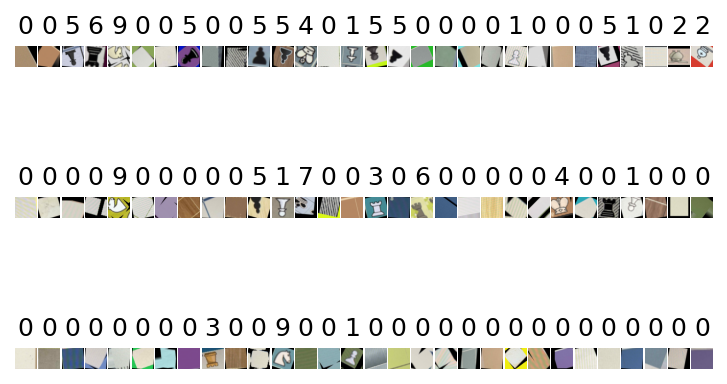

In [8]:
ctr = 90

for idx, (x, label) in enumerate(training_data_generator()):
    plt.subplot(3, 30, idx+1)
    plt.imshow(x/255)
    plt.axis("off")
    plt.title(label)
    ctr -= 1
    if ctr <= 0:
        break
plt.gcf().set_dpi(150)
plt.subplots_adjust(hspace = 0, wspace=0.1)
plt.show()

0


1


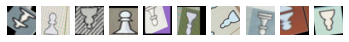

2


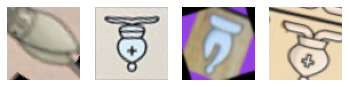

3


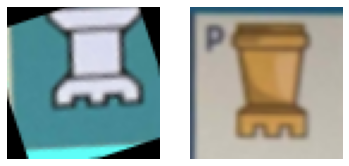

4


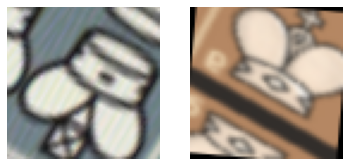

5


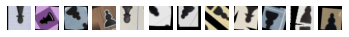

6


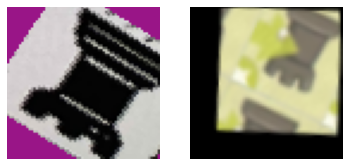

7


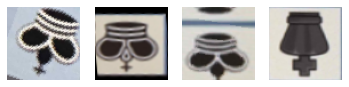

9


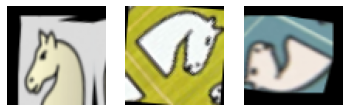

10


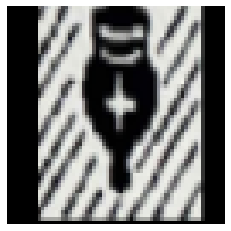

12


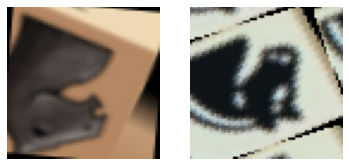

In [9]:
ctr = 10*13

label_generations = {}

for idx, (x, label) in enumerate(training_data_generator()):
    if label not in label_generations:
        label_generations[label] = []
    label_generations[label].append(x)
    ctr -= 1
    if ctr <= 0:
        break

        
for label, generations in sorted(label_generations.items()):
    print(label)
    
    for i in range(len(generations)):
        plt.subplot(1, len(generations), i+1)
        plt.axis("off")
        plt.imshow(generations[i]/255)
    plt.show()
    

In [10]:
def val_data_generator():
    for val_file, image_file in zip(val_files, val_images):       
        file_name, ext = os.path.splitext(val_file)
        file_meta = file_name.split("_")
        file_class = int(file_meta[2])       
        
        image_file = np.array(image_file).astype(np.float32)
        
        yield image_file, file_class

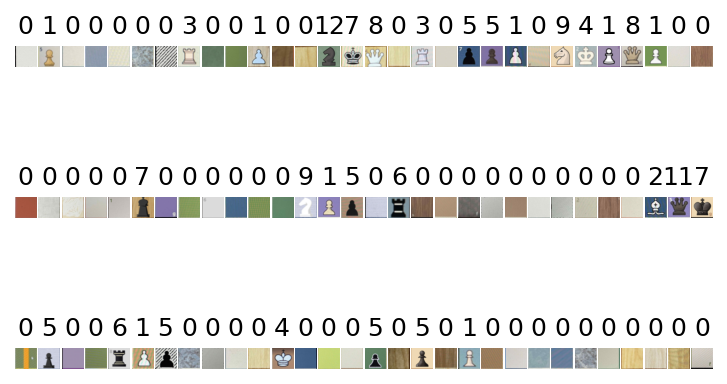

In [11]:
ctr = 90

for idx, (x, label) in enumerate(val_data_generator()):
    plt.subplot(3, 30, idx+1)
    plt.imshow(x/255)
    plt.axis("off")
    plt.title(label)
    ctr -= 1
    if ctr <= 0:
        break
plt.gcf().set_dpi(150)
plt.subplots_adjust(hspace = 0, wspace=0.1)
plt.show()

In [12]:
import json

with open(os.path.join(DATASET_PATH, "class_map.json"), 'r') as cf:
    class_map = json.load(cf)

class_map

{'0': 'Empty',
 '1': 'White pawn',
 '2': 'White bishop',
 '3': 'White rook',
 '4': 'White king',
 '5': 'Black pawn',
 '6': 'Black rook',
 '7': 'Black king',
 '8': 'White queen',
 '9': 'White knight',
 '10': 'Black bishop',
 '11': 'Black queen',
 '12': 'Black knight'}

In [13]:
n_classes = max(int(v) for v in class_map.keys()) + 1

In [14]:
class_prior = {int(cls): 0 for cls in class_map.keys()}

for image, label in training_data_generator():
    class_prior[label] += 1

In [15]:
total_samples = len(train_files)

class_prior_perc = {
    k: f"{100*v/total_samples:.2f}%" for k,v in class_prior.items()
}

def normalize_dict(d):
    valsum = sum(d.values())
    maxval = max(d.values())/valsum
    return {k:v/valsum/maxval for k,v in d.items()}

class_weights = {k: 1/v for k,v in class_prior.items()}
class_weights = normalize_dict(class_weights)

print(class_prior_perc)
print()
print(class_weights)

{0: '65.53%', 1: '8.69%', 2: '2.04%', 3: '2.35%', 4: '1.57%', 5: '8.81%', 6: '2.26%', 7: '1.54%', 8: '1.02%', 9: '1.47%', 10: '1.83%', 11: '1.16%', 12: '1.73%'}

{0: 0.015579710144927535, 1: 0.1174863387978142, 2: 0.5, 3: 0.4343434343434343, 4: 0.6515151515151515, 5: 0.11590296495956873, 6: 0.4526315789473684, 7: 0.6615384615384615, 8: 1.0, 9: 0.6935483870967741, 10: 0.5584415584415584, 11: 0.8775510204081632, 12: 0.589041095890411}


In [16]:
# Redefine generator to account for weights

def training_data_generator():
    n_returned = 0
    train_index = 0
    while n_returned < 768*40:
        
        train_file = train_files[train_index % len(train_files)]
        image_file = train_images[train_index % len(train_files)]
        
        train_index += 1
        
        file_name, ext = os.path.splitext(train_file)
        file_meta = file_name.split("_")
        file_class = int(file_meta[2])       

        chance = np.random.rand()
        if chance > class_weights[file_class]:
            continue
            
        n_returned += 1
            
        image_aug = aug_pipeline(image=np.array(image_file))

        image_aug = np.array(image_aug).astype(np.float32)

        yield image_aug, file_class

0


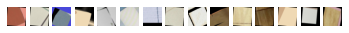

1


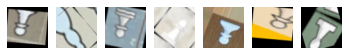

2


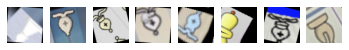

3


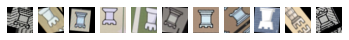

4


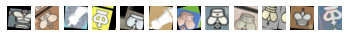

5


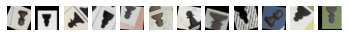

6


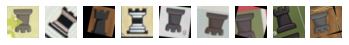

7


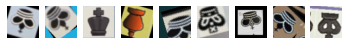

8


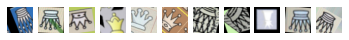

9


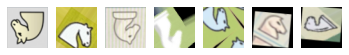

10


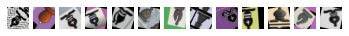

11


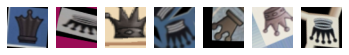

12


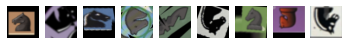

In [17]:
ctr = 10*13

label_generations = {}

for idx, (x, label) in enumerate(training_data_generator()):
    if label not in label_generations:
        label_generations[label] = []
    label_generations[label].append(x)
    ctr -= 1
    if ctr <= 0:
        break

        
for label, generations in sorted(label_generations.items()):
    print(label)
    
    for i in range(len(generations)):
        plt.subplot(1, len(generations), i+1)
        plt.axis("off")
        plt.imshow(generations[i]/255)
    plt.show()
    

In [18]:
def make_conv_block(filters, activation="relu", dropout=0.3, kernel_size=3):
    return keras.models.Sequential([
        keras.layers.Conv2D(
            filters=filters,
            activation=None,
            padding="same",
            kernel_size=(3,3)
        ),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation),
        keras.layers.Dropout(rate=dropout),
        keras.layers.Conv2D(
            filters=filters,
            activation=None,
            padding="same",
            kernel_size=(3,3)
        ),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation),
        keras.layers.MaxPool2D(pool_size=2)
    ])
    
def make_conv_classifier():
    return keras.models.Sequential([
        keras.layers.Rescaling(scale=1/255.),
        make_conv_block(8), # 32
        make_conv_block(16), # 16
        make_conv_block(32), # 8
        make_conv_block(64), # 4
        make_conv_block(128), # 2
        make_conv_block(128), # 1
        keras.layers.Flatten(),
        keras.layers.Dense(n_classes, activation="softmax")
    ])
    
    
conv_clf = make_conv_classifier()
conv_clf.build(input_shape=(None, 64,64,3))
conv_clf.summary()

2022-11-17 12:31:01.785512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 12:31:01.805730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 12:31:01.805929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 12:31:01.806462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 8)         872       
                                                                 
 sequential_1 (Sequential)   (None, 16, 16, 16)        3616      
                                                                 
 sequential_2 (Sequential)   (None, 8, 8, 32)          14144     
                                                                 
 sequential_3 (Sequential)   (None, 4, 4, 64)          55936     
                                                                 
 sequential_4 (Sequential)   (None, 2, 2, 128)         222464    
                                                                 
 sequential_5 (Sequential)   (None, 1, 1, 128)        

In [19]:
figure_classifier = keras.models.Sequential([
    keras.applications.MobileNetV3Large(
        input_shape=(64, 64, 3),
        alpha=1.0,
        include_top=False,
        classes=n_classes,
        weights="imagenet",
    ),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(13, activation="softmax")
])

In [20]:
figure_classifier.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [21]:
train_dataset = tf.data.Dataset.from_generator(
    training_data_generator,
    output_types=(tf.float32, tf.int32),
    output_shapes=((64, 64, 3), None)
).batch(768).prefetch(10)

val_dataset = tf.data.Dataset.from_generator(
    val_data_generator,
    output_types=(tf.float32, tf.int32),
    output_shapes=((64, 64, 3), None)
).batch(256).prefetch(2)

In [22]:
class LogMemoryCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        logs['GPU_mem_usage'] = tf.config.experimental.get_memory_info('GPU:0')['current']

class LogRealMemoryCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        smi_ret = subprocess.check_output(['nvidia-smi --query-gpu=memory.used --format=csv,noheader,nounits'], shell=True).decode('utf-8')

        logs['REAL_GPU_mem_usage'] = int(smi_ret)*1048576

In [23]:
figure_classifier.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1500,
    callbacks=[
        LogMemoryCallback(),
        LogRealMemoryCallback(),
        keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True),
        keras.callbacks.TensorBoard(log_dir='classifier_logs'),
        keras.callbacks.ModelCheckpoint(save_freq=300, filepath='clf_checkpoint')
    ]
)

Epoch 1/1500


2022-11-17 12:31:11.678729: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2022-11-17 12:31:12.342296: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


40/40 [==============================] - 82s 2s/step - loss: 2.6559 - sparse_categorical_accuracy: 0.2404 - val_loss: 2.3499 - val_sparse_categorical_accuracy: 0.2184 - GPU_mem_usage: 39419904.0000 - REAL_GPU_mem_usage: 7506755584.0000
Epoch 2/1500
40/40 [==============================] - 79s 2s/step - loss: 1.3635 - sparse_categorical_accuracy: 0.5720 - val_loss: 2.0550 - val_sparse_categorical_accuracy: 0.3886 - GPU_mem_usage: 39423744.0000 - REAL_GPU_mem_usage: 7507804160.0000
Epoch 3/1500
40/40 [==============================] - 80s 2s/step - loss: 0.7703 - sparse_categorical_accuracy: 0.7608 - val_loss: 1.7733 - val_sparse_categorical_accuracy: 0.5166 - GPU_mem_usage: 39422208.0000 - REAL_GPU_mem_usage: 7507804160.0000
Epoch 4/1500
40/40 [==============================] - 79s 2s/step - loss: 0.4794 - sparse_categorical_accuracy: 0.8516 - val_loss: 1.5202 - val_sparse_categorical_accuracy: 0.6048 - GPU_mem_usage: 39421440.0000 - REAL_GPU_mem_usage: 7506755584.0000
Epoch 5/1500
40/4

INFO:tensorflow:Assets written to: clf_checkpoint/assets


INFO:tensorflow:Assets written to: clf_checkpoint/assets


40/40 [==============================] - 117s 3s/step - loss: 0.1481 - sparse_categorical_accuracy: 0.9539 - val_loss: 0.8424 - val_sparse_categorical_accuracy: 0.8121 - GPU_mem_usage: 39427072.0000 - REAL_GPU_mem_usage: 7497318400.0000
Epoch 9/1500
40/40 [==============================] - 79s 2s/step - loss: 0.1190 - sparse_categorical_accuracy: 0.9634 - val_loss: 0.7038 - val_sparse_categorical_accuracy: 0.8453 - GPU_mem_usage: 39430400.0000 - REAL_GPU_mem_usage: 7476346880.0000
Epoch 10/1500
40/40 [==============================] - 79s 2s/step - loss: 0.1022 - sparse_categorical_accuracy: 0.9674 - val_loss: 0.5837 - val_sparse_categorical_accuracy: 0.8686 - GPU_mem_usage: 39433984.0000 - REAL_GPU_mem_usage: 7486832640.0000
Epoch 11/1500
40/40 [==============================] - 79s 2s/step - loss: 0.0889 - sparse_categorical_accuracy: 0.9720 - val_loss: 0.4917 - val_sparse_categorical_accuracy: 0.8930 - GPU_mem_usage: 39437568.0000 - REAL_GPU_mem_usage: 7486832640.0000
Epoch 12/1500


INFO:tensorflow:Assets written to: clf_checkpoint/assets


INFO:tensorflow:Assets written to: clf_checkpoint/assets


40/40 [==============================] - 98s 2s/step - loss: 0.0578 - sparse_categorical_accuracy: 0.9820 - val_loss: 0.2889 - val_sparse_categorical_accuracy: 0.9329 - GPU_mem_usage: 39440128.0000 - REAL_GPU_mem_usage: 7499415552.0000
Epoch 16/1500
40/40 [==============================] - 92s 2s/step - loss: 0.0500 - sparse_categorical_accuracy: 0.9848 - val_loss: 0.2527 - val_sparse_categorical_accuracy: 0.9401 - GPU_mem_usage: 39440128.0000 - REAL_GPU_mem_usage: 7510949888.0000
Epoch 17/1500
40/40 [==============================] - 87s 2s/step - loss: 0.0468 - sparse_categorical_accuracy: 0.9858 - val_loss: 0.2318 - val_sparse_categorical_accuracy: 0.9451 - GPU_mem_usage: 39443712.0000 - REAL_GPU_mem_usage: 7577010176.0000
Epoch 18/1500
40/40 [==============================] - 82s 2s/step - loss: 0.0444 - sparse_categorical_accuracy: 0.9858 - val_loss: 0.1991 - val_sparse_categorical_accuracy: 0.9534 - GPU_mem_usage: 39448064.0000 - REAL_GPU_mem_usage: 7574913024.0000
Epoch 19/1500


INFO:tensorflow:Assets written to: clf_checkpoint/assets


INFO:tensorflow:Assets written to: clf_checkpoint/assets


40/40 [==============================] - 120s 3s/step - loss: 0.0324 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.1253 - val_sparse_categorical_accuracy: 0.9695 - GPU_mem_usage: 39451392.0000 - REAL_GPU_mem_usage: 7593787392.0000
Epoch 24/1500
40/40 [==============================] - 78s 2s/step - loss: 0.0289 - sparse_categorical_accuracy: 0.9908 - val_loss: 0.1149 - val_sparse_categorical_accuracy: 0.9728 - GPU_mem_usage: 39453696.0000 - REAL_GPU_mem_usage: 7593787392.0000
Epoch 25/1500
40/40 [==============================] - 79s 2s/step - loss: 0.0291 - sparse_categorical_accuracy: 0.9908 - val_loss: 0.1050 - val_sparse_categorical_accuracy: 0.9734 - GPU_mem_usage: 39456000.0000 - REAL_GPU_mem_usage: 7603224576.0000
Epoch 26/1500
40/40 [==============================] - 79s 2s/step - loss: 0.0287 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.0970 - val_sparse_categorical_accuracy: 0.9773 - GPU_mem_usage: 39454208.0000 - REAL_GPU_mem_usage: 7556038656.0000
Epoch 27/1500

INFO:tensorflow:Assets written to: clf_checkpoint/assets


INFO:tensorflow:Assets written to: clf_checkpoint/assets


40/40 [==============================] - 96s 2s/step - loss: 0.0217 - sparse_categorical_accuracy: 0.9933 - val_loss: 0.0723 - val_sparse_categorical_accuracy: 0.9834 - GPU_mem_usage: 39465472.0000 - REAL_GPU_mem_usage: 7556038656.0000
Epoch 31/1500
40/40 [==============================] - 78s 2s/step - loss: 0.0201 - sparse_categorical_accuracy: 0.9940 - val_loss: 0.0702 - val_sparse_categorical_accuracy: 0.9845 - GPU_mem_usage: 39460352.0000 - REAL_GPU_mem_usage: 7556038656.0000
Epoch 32/1500
40/40 [==============================] - 78s 2s/step - loss: 0.0201 - sparse_categorical_accuracy: 0.9932 - val_loss: 0.0684 - val_sparse_categorical_accuracy: 0.9850 - GPU_mem_usage: 39463424.0000 - REAL_GPU_mem_usage: 7556038656.0000
Epoch 33/1500
40/40 [==============================] - 78s 2s/step - loss: 0.0190 - sparse_categorical_accuracy: 0.9937 - val_loss: 0.0656 - val_sparse_categorical_accuracy: 0.9867 - GPU_mem_usage: 39468288.0000 - REAL_GPU_mem_usage: 7556038656.0000
Epoch 34/1500


INFO:tensorflow:Assets written to: clf_checkpoint/assets


INFO:tensorflow:Assets written to: clf_checkpoint/assets


40/40 [==============================] - 114s 3s/step - loss: 0.0148 - sparse_categorical_accuracy: 0.9952 - val_loss: 0.0542 - val_sparse_categorical_accuracy: 0.9906 - GPU_mem_usage: 39470336.0000 - REAL_GPU_mem_usage: 7586447360.0000
Epoch 39/1500
40/40 [==============================] - 79s 2s/step - loss: 0.0159 - sparse_categorical_accuracy: 0.9944 - val_loss: 0.0536 - val_sparse_categorical_accuracy: 0.9900 - GPU_mem_usage: 39470592.0000 - REAL_GPU_mem_usage: 7585398784.0000
Epoch 40/1500
40/40 [==============================] - 78s 2s/step - loss: 0.0151 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.0521 - val_sparse_categorical_accuracy: 0.9906 - GPU_mem_usage: 39470592.0000 - REAL_GPU_mem_usage: 7585398784.0000
Epoch 41/1500
40/40 [==============================] - 78s 2s/step - loss: 0.0159 - sparse_categorical_accuracy: 0.9948 - val_loss: 0.0486 - val_sparse_categorical_accuracy: 0.9906 - GPU_mem_usage: 39476736.0000 - REAL_GPU_mem_usage: 7585398784.0000
Epoch 42/1500

INFO:tensorflow:Assets written to: clf_checkpoint/assets


INFO:tensorflow:Assets written to: clf_checkpoint/assets


40/40 [==============================] - 96s 2s/step - loss: 0.0121 - sparse_categorical_accuracy: 0.9965 - val_loss: 0.0414 - val_sparse_categorical_accuracy: 0.9928 - GPU_mem_usage: 39480832.0000 - REAL_GPU_mem_usage: 7556038656.0000
Epoch 46/1500
40/40 [==============================] - 80s 2s/step - loss: 0.0116 - sparse_categorical_accuracy: 0.9962 - val_loss: 0.0417 - val_sparse_categorical_accuracy: 0.9928 - GPU_mem_usage: 39478784.0000 - REAL_GPU_mem_usage: 7556038656.0000
Epoch 47/1500
40/40 [==============================] - 79s 2s/step - loss: 0.0131 - sparse_categorical_accuracy: 0.9958 - val_loss: 0.0418 - val_sparse_categorical_accuracy: 0.9933 - GPU_mem_usage: 39478528.0000 - REAL_GPU_mem_usage: 7556038656.0000
Epoch 48/1500
40/40 [==============================] - 79s 2s/step - loss: 0.0123 - sparse_categorical_accuracy: 0.9958 - val_loss: 0.0410 - val_sparse_categorical_accuracy: 0.9939 - GPU_mem_usage: 39486976.0000 - REAL_GPU_mem_usage: 7545552896.0000
Epoch 49/1500


INFO:tensorflow:Assets written to: clf_checkpoint/assets


INFO:tensorflow:Assets written to: clf_checkpoint/assets


40/40 [==============================] - 120s 3s/step - loss: 0.0104 - sparse_categorical_accuracy: 0.9967 - val_loss: 0.0435 - val_sparse_categorical_accuracy: 0.9933 - GPU_mem_usage: 39484416.0000 - REAL_GPU_mem_usage: 7572815872.0000
Epoch 54/1500
40/40 [==============================] - 82s 2s/step - loss: 0.0110 - sparse_categorical_accuracy: 0.9968 - val_loss: 0.0414 - val_sparse_categorical_accuracy: 0.9933 - GPU_mem_usage: 39487488.0000 - REAL_GPU_mem_usage: 7572815872.0000
Epoch 55/1500
40/40 [==============================] - 78s 2s/step - loss: 0.0096 - sparse_categorical_accuracy: 0.9967 - val_loss: 0.0408 - val_sparse_categorical_accuracy: 0.9933 - GPU_mem_usage: 39489280.0000 - REAL_GPU_mem_usage: 7572815872.0000
Epoch 56/1500
40/40 [==============================] - 76s 2s/step - loss: 0.0112 - sparse_categorical_accuracy: 0.9964 - val_loss: 0.0409 - val_sparse_categorical_accuracy: 0.9939 - GPU_mem_usage: 39488256.0000 - REAL_GPU_mem_usage: 7583301632.0000
Epoch 57/1500

INFO:tensorflow:Assets written to: clf_checkpoint/assets


INFO:tensorflow:Assets written to: clf_checkpoint/assets


40/40 [==============================] - 104s 3s/step - loss: 0.0093 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.0428 - val_sparse_categorical_accuracy: 0.9939 - GPU_mem_usage: 39492096.0000 - REAL_GPU_mem_usage: 7582253056.0000
Epoch 61/1500
40/40 [==============================] - 88s 2s/step - loss: 0.0084 - sparse_categorical_accuracy: 0.9976 - val_loss: 0.0400 - val_sparse_categorical_accuracy: 0.9939 - GPU_mem_usage: 39496192.0000 - REAL_GPU_mem_usage: 7589593088.0000
Epoch 62/1500
40/40 [==============================] - 80s 2s/step - loss: 0.0082 - sparse_categorical_accuracy: 0.9974 - val_loss: 0.0399 - val_sparse_categorical_accuracy: 0.9939 - GPU_mem_usage: 39496192.0000 - REAL_GPU_mem_usage: 7579107328.0000
Epoch 63/1500
40/40 [==============================] - 78s 2s/step - loss: 0.0082 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0397 - val_sparse_categorical_accuracy: 0.9945 - GPU_mem_usage: 39505408.0000 - REAL_GPU_mem_usage: 7589593088.0000
Epoch 64/1500

INFO:tensorflow:Assets written to: clf_checkpoint/assets


INFO:tensorflow:Assets written to: clf_checkpoint/assets


40/40 [==============================] - 132s 3s/step - loss: 0.0073 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.0380 - val_sparse_categorical_accuracy: 0.9945 - GPU_mem_usage: 39509248.0000 - REAL_GPU_mem_usage: 7655653376.0000
Epoch 69/1500
40/40 [==============================] - 88s 2s/step - loss: 0.0071 - sparse_categorical_accuracy: 0.9973 - val_loss: 0.0401 - val_sparse_categorical_accuracy: 0.9950 - GPU_mem_usage: 39507456.0000 - REAL_GPU_mem_usage: 7731150848.0000
Epoch 70/1500
40/40 [==============================] - 88s 2s/step - loss: 0.0076 - sparse_categorical_accuracy: 0.9979 - val_loss: 0.0372 - val_sparse_categorical_accuracy: 0.9950 - GPU_mem_usage: 39511040.0000 - REAL_GPU_mem_usage: 7672430592.0000
Epoch 71/1500
40/40 [==============================] - 89s 2s/step - loss: 0.0084 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0376 - val_sparse_categorical_accuracy: 0.9945 - GPU_mem_usage: 39507200.0000 - REAL_GPU_mem_usage: 7719616512.0000
Epoch 72/1500

KeyboardInterrupt: 

tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(1, 13), dtype=float32)


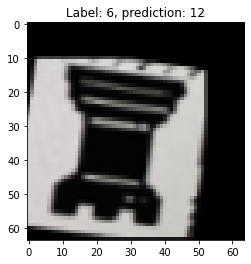

tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]], shape=(1, 13), dtype=float32)


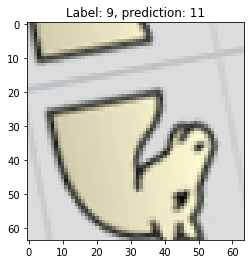

tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]], shape=(1, 13), dtype=float32)


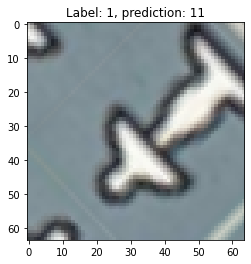

tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]], shape=(1, 13), dtype=float32)


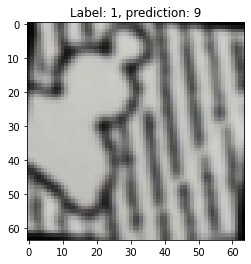

tf.Tensor([[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 13), dtype=float32)


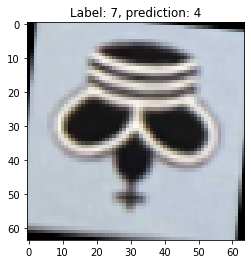

tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]], shape=(1, 13), dtype=float32)


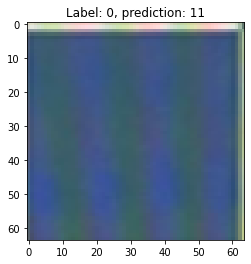

tf.Tensor([[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 13), dtype=float32)


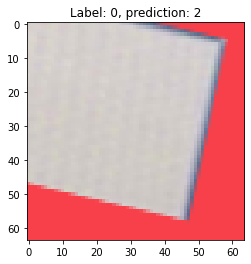

tf.Tensor([[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 13), dtype=float32)


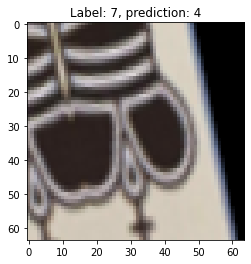

tf.Tensor([[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 13), dtype=float32)


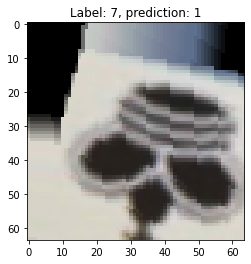

tf.Tensor([[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 13), dtype=float32)


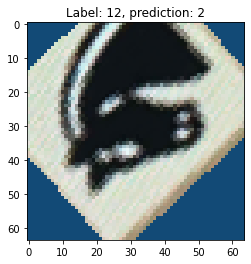

tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]], shape=(1, 13), dtype=float32)


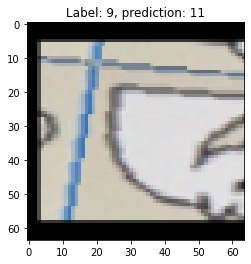

In [24]:
ctr = 0

for val_file, val_label in training_data_generator():
    plt.imshow(val_file/255)
    pred = figure_classifier(tf.expand_dims(val_file*255, axis=0))
    print(pred)
    target = np.argmax(pred)
    plt.title(f"Label: {val_label}, prediction: {target}")
    plt.show()
    ctr += 1
    if ctr > 10:
        break

In [ ]:
tf.config.experimental.get_memory_info('GPU:0')